In [0]:
spark.catalog.listDatabases()
spark.sql("CREATE DATABASE IF NOT EXISTS walmart_sales_db")


Out[1]: DataFrame[]

In [0]:
spark.catalog.listTables("walmart_sales_db")


Out[2]: [Table(name='walmart_sales', database='walmart_sales_db', description=None, tableType='MANAGED', isTemporary=False)]

In [0]:
import boto3

s3 = boto3.client('s3', aws_access_key_id="REPLACE_WITH_KEY", aws_secret_access_key="REPLACE_WITH_SECRET")

bucket_name = "walmart-sales-dataset"
prefix = "processed/" 

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

if "Contents" in response:
    for obj in response["Contents"]:
        print(obj["Key"])  
else:
    print("No files found in the specified S3 path.")


processed/part-00000-499ad812-f772-430d-b327-aad6498eafac-c000.snappy.parquet


In [0]:
import os
import boto3

os.environ['AWS_ACCESS_KEY_ID'] = 'REPLACE_WITH_KEY'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'REPLACE_WITH_SECRET'

s3 = boto3.client('s3')

bucket_name = "walmart-sales-dataset"
file_key = "processed/part-00000-499ad812-f772-430d-b327-aad6498eafac-c000.snappy.parquet"
local_file_path = "/tmp/walmart_sales.parquet"

s3.download_file(bucket_name, file_key, local_file_path)

dbutils.fs.cp(f"file:{local_file_path}", "dbfs:/tmp/walmart_sales.parquet")

df = spark.read.parquet("dbfs:/tmp/walmart_sales.parquet")
df.show(5)

+-----+----------+----------+-----------+-----------+------------+----------+
|Store|      Date|Fuel_Price|Temperature|        CPI|Unemployment|     Sales|
+-----+----------+----------+-----------+-----------+------------+----------+
|    1|05-02-2010|     2.572|      42.31|211.0963582|       8.106| 1643690.9|
|    1|12-02-2010|     2.548|      38.51|211.2421698|       8.106|1641957.44|
|    1|19-02-2010|     2.514|      39.93|211.2891429|       8.106|1611968.17|
|    1|26-02-2010|     2.561|      46.63|211.3196429|       8.106|1409727.59|
|    1|05-03-2010|     2.625|       46.5|211.3501429|       8.106|1554806.68|
+-----+----------+----------+-----------+-----------+------------+----------+
only showing top 5 rows



In [0]:
df.write.mode("overwrite").saveAsTable("walmart_sales_db.walmart_sales")


In [0]:
spark.sql("SHOW TABLES IN walmart_sales_db").show()


+----------------+-------------+-----------+
|        database|    tableName|isTemporary|
+----------------+-------------+-----------+
|walmart_sales_db|walmart_sales|      false|
+----------------+-------------+-----------+



In [0]:
df.printSchema()


root
 |-- Store: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Sales: double (nullable = true)



In [0]:
df.count()


Out[8]: 6435

In [0]:
df.describe().show()


+-------+------------------+----------+-------------------+------------------+-----------------+------------------+------------------+
|summary|             Store|      Date|         Fuel_Price|       Temperature|              CPI|      Unemployment|             Sales|
+-------+------------------+----------+-------------------+------------------+-----------------+------------------+------------------+
|  count|              6435|      6435|               6435|              6435|             6435|              6435|              6435|
|   mean|              23.0|      null|  3.358606837606832| 60.66378243978229|171.5783938487799| 7.999151048951067|1046964.8775617732|
| stddev|12.988182381175454|      null|0.45901970719285223|18.444932875811585|39.35671229566419|1.8758847818627944| 564366.6220536977|
|    min|                 1|01-04-2011|              2.472|             -2.06|          126.064|             3.879|         209986.25|
|    max|                45|31-12-2010|              4.

In [0]:
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+-----+----+----------+-----------+---+------------+-----+
|Store|Date|Fuel_Price|Temperature|CPI|Unemployment|Sales|
+-----+----+----------+-----------+---+------------+-----+
|    0|   0|         0|          0|  0|           0|    0|
+-----+----+----------+-----------+---+------------+-----+



In [0]:
from pyspark.sql.functions import to_date

df = df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
df.printSchema()


root
 |-- Store: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Fuel_Price: double (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- CPI: double (nullable = true)
 |-- Unemployment: double (nullable = true)
 |-- Sales: double (nullable = true)



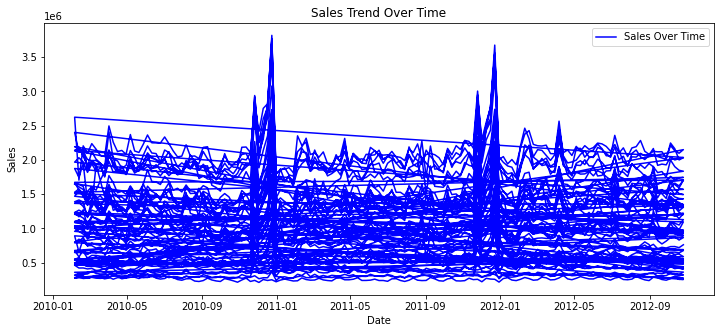

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = df.select("Date", "Sales").toPandas()
pdf.set_index("Date", inplace=True)

plt.figure(figsize=(12,5))
plt.plot(pdf.index, pdf["Sales"], label="Sales Over Time", color="blue")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Trend Over Time")
plt.legend()
plt.show()


In [0]:
from pyspark.sql.functions import year, month, dayofweek, weekofyear, col, when

df = df.withColumn("Year", year(col("Date")))
df = df.withColumn("Month", month(col("Date")))
df = df.withColumn("WeekOfYear", weekofyear(col("Date")))
df = df.withColumn("DayOfWeek", dayofweek(col("Date")))
df = df.withColumn("IsWeekend", when(col("DayOfWeek").isin([1, 7]), 1).otherwise(0))


In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

window_spec = Window.partitionBy("Store").orderBy("Date")

df = df.withColumn("Sales_Lag_1", lag("Sales", 1).over(window_spec))
df = df.withColumn("Sales_Lag_7", lag("Sales", 7).over(window_spec)) # 1-week lag
df = df.withColumn("Sales_Lag_30", lag("Sales", 30).over(window_spec)) # 1-month lag




In [0]:
from pyspark.sql.functions import avg

df = df.withColumn("Sales_MA_7", avg("Sales").over(window_spec.rowsBetween(-6, 0)))
df = df.withColumn("Sales_MA_30", avg("Sales").over(window_spec.rowsBetween(-29, 0)))


In [0]:
df.select("Store", "Date", "Sales", "Sales_Lag_1", "Sales_Lag_7", "Sales_MA_7", "IsWeekend").show(10)


+-----+----------+----------+-----------+-----------+------------------+---------+
|Store|      Date|     Sales|Sales_Lag_1|Sales_Lag_7|        Sales_MA_7|IsWeekend|
+-----+----------+----------+-----------+-----------+------------------+---------+
|    1|2010-02-05| 1643690.9|       null|       null|         1643690.9|        0|
|    1|2010-02-12|1641957.44|  1643690.9|       null|        1642824.17|        0|
|    1|2010-02-19|1611968.17| 1641957.44|       null|1632538.8366666667|        0|
|    1|2010-02-26|1409727.59| 1611968.17|       null|       1576836.025|        0|
|    1|2010-03-05|1554806.68| 1409727.59|       null|       1572430.156|        0|
|    1|2010-03-12|1439541.59| 1554806.68|       null|1550282.0616666665|        0|
|    1|2010-03-19|1472515.79| 1439541.59|       null|1539172.5942857142|        0|
|    1|2010-03-26|1404429.92| 1472515.79|  1643690.9|1504992.4542857143|        0|
|    1|2010-04-02|1594968.28| 1404429.92| 1641957.44| 1498279.717142857|        0|
|   

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, avg, col, dayofweek, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

df = spark.read.parquet("dbfs:/tmp/walmart_sales.parquet")

window_spec = Window().partitionBy("Store").orderBy("Date")

df = df.withColumn("Sales_Lag_1", lag("Sales", 1).over(window_spec))
df = df.withColumn("Sales_Lag_7", lag("Sales", 7).over(window_spec))
df = df.withColumn("Sales_MA_7", avg("Sales").over(window_spec.rowsBetween(-6, 0)))

df = df.withColumn("IsWeekend", when(dayofweek(col("Date")).isin([1, 7]), 1).otherwise(0))
df = df.dropna()

# Feature scaling
features = ["Sales_Lag_1", "Sales_Lag_7", "Sales_MA_7", "IsWeekend"]
assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

# Create pipeline
pipeline = Pipeline(stages=[assembler, scaler])

df_scaled = pipeline.fit(df).transform(df)

df_scaled.select("Store", "Date", "Sales", "scaled_features").show(10)


+-----+----------+----------+--------------------+
|Store|      Date|     Sales|     scaled_features|
+-----+----------+----------+--------------------+
|    1|02-09-2011|1550229.22|[2.63760193573708...|
|    1|02-12-2011|1584083.95|[2.73977344680907...|
|    1|03-02-2012|1636339.65|[2.79960607614300...|
|    1|03-06-2011|1635078.41|[2.89195937296992...|
|    1|03-08-2012|1631135.79|[2.88973034011628...|
|    1|03-09-2010|1540163.53|[2.88276241211731...|
|    1|03-12-2010|1548033.78|[2.72198400649274...|
|    1|04-02-2011|1606629.58|[2.73589337014785...|
|    1|04-03-2011|1636263.41|[2.83945174387953...|
|    1|04-05-2012|1684519.99|[2.89182463139436...|
+-----+----------+----------+--------------------+
only showing top 10 rows



In [0]:
%pip install xgboost

Python interpreter will be restarted.
  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl (223.6 MB)
  Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (201.4 MB)
Python interpreter will be restarted.


RMSE: 88836.36942536767


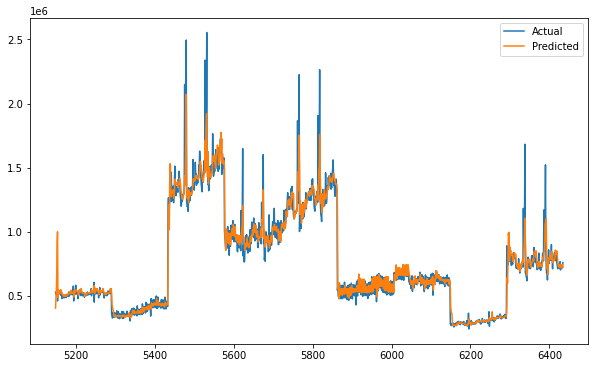

In [0]:

from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = spark.read.parquet("dbfs:/tmp/walmart_sales.parquet")

df = df.toPandas()

# Feature engineering: Create lag features
df['Sales_Lag_1'] = df['Sales'].shift(1)
df['Sales_Lag_7'] = df['Sales'].shift(7)
df['Sales_MA_7'] = df['Sales'].rolling(window=7).mean()

df = df.dropna()

X = df[['Sales_Lag_1', 'Sales_Lag_7', 'Sales_MA_7']]
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,  # Depth of the trees
    'eta': 0.1,  # Learning rate
    'eval_metric': 'rmse',  # Metric to evaluate performance
}

model = xgb.train(params, dtrain, num_boost_round=100)

y_pred = model.predict(dtest)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()


In [0]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}

xgb_regressor = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
RMSE: 95339.69860925149


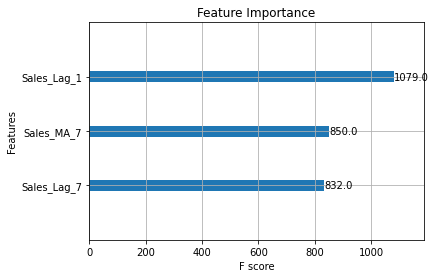

In [0]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()


In [0]:
%pip install bayesian-optimization


Python interpreter will be restarted.
  Using cached bayesian_optimization-1.4.3-py3-none-any.whl (18 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Python interpreter will be restarted.


Final Optimized RMSE: 139862.26308526853


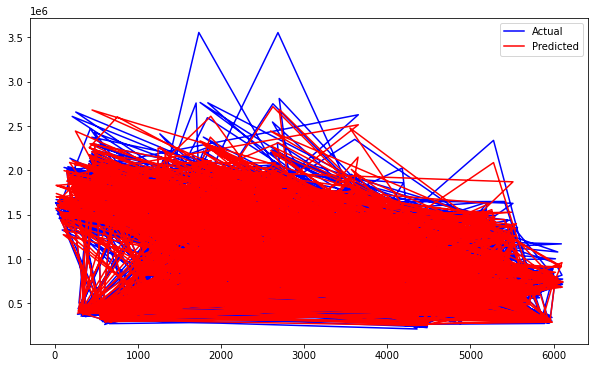

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, avg, col, dayofweek, when
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = spark.read.parquet("dbfs:/tmp/walmart_sales.parquet")

window_spec = Window().partitionBy("Store").orderBy("Date")

df = df.withColumn("Sales_Lag_1", lag("Sales", 1).over(window_spec))
df = df.withColumn("Sales_Lag_7", lag("Sales", 7).over(window_spec))
df = df.withColumn("Sales_MA_7", avg("Sales").over(window_spec.rowsBetween(-6, 0)))

df = df.withColumn("IsWeekend", when(dayofweek(col("Date")).isin([1, 7]), 1).otherwise(0))

df = df.dropna()

df_pd = df.toPandas()
features = ["Sales_Lag_1", "Sales_Lag_7", "Sales_MA_7", "IsWeekend"]
target = "Sales"

X = df_pd[features]
y = df_pd[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(
    n_estimators=142,
    learning_rate=0.194,
    max_depth=5,
    subsample=0.634,
    colsample_bytree=0.978,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Optimized RMSE: {rmse}")

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual', color="blue")
plt.plot(y_test.index, y_pred, label='Predicted', color="red")
plt.legend()
plt.show()


In [0]:
!pip install tensorflow

  Using cached tensorflow-2.13.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (479.6 MB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached wrapt-1.17.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (85 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl (24.5 MB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached numpy-1.24.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl (294 k

In [0]:
%pip install --upgrade tensorflow
%pip install numpy


Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


Epoch 1/20
153/153 - 2s - loss: 1585037574144.0000 - 2s/epoch - 16ms/step
Epoch 2/20
153/153 - 1s - loss: 1585006641152.0000 - 600ms/epoch - 4ms/step
Epoch 3/20
153/153 - 1s - loss: 1584983179264.0000 - 642ms/epoch - 4ms/step
Epoch 4/20
153/153 - 1s - loss: 1584959586304.0000 - 596ms/epoch - 4ms/step
Epoch 5/20
153/153 - 1s - loss: 1584937435136.0000 - 638ms/epoch - 4ms/step
Epoch 6/20
153/153 - 1s - loss: 1584914235392.0000 - 625ms/epoch - 4ms/step
Epoch 7/20
153/153 - 1s - loss: 1584891691008.0000 - 613ms/epoch - 4ms/step
Epoch 8/20
153/153 - 1s - loss: 1584869539840.0000 - 592ms/epoch - 4ms/step
Epoch 9/20
153/153 - 1s - loss: 1584847257600.0000 - 588ms/epoch - 4ms/step
Epoch 10/20
153/153 - 1s - loss: 1584824844288.0000 - 663ms/epoch - 4ms/step
Epoch 11/20
153/153 - 1s - loss: 1584802824192.0000 - 619ms/epoch - 4ms/step
Epoch 12/20
153/153 - 1s - loss: 1584780673024.0000 - 627ms/epoch - 4ms/step
Epoch 13/20
153/153 - 1s - loss: 1584758128640.0000 - 580ms/epoch - 4ms/step
Epoch 14/2

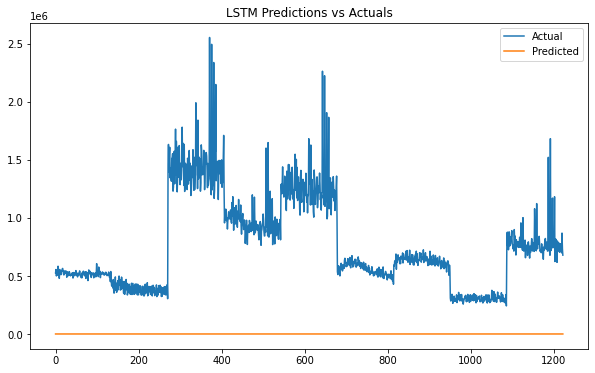

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import lag, avg, col, dayofweek, when
from pyspark.sql.window import Window
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


df = spark.read.parquet("dbfs:/tmp/walmart_sales.parquet")

window_spec = Window.partitionBy("Store").orderBy("Date")

df = df.withColumn("Sales_Lag_1", lag("Sales", 1).over(window_spec))
df = df.withColumn("Sales_Lag_7", lag("Sales", 7).over(window_spec))
df = df.withColumn("Sales_MA_7", avg("Sales").over(window_spec.rowsBetween(-6, 0)))

df = df.withColumn("IsWeekend", when(dayofweek(col("Date")).isin([1, 7]), 1).otherwise(0))

df = df.dropna()

df_pd = df.toPandas()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_pd[['Sales_Lag_1', 'Sales_Lag_7', 'Sales_MA_7']])

def create_lstm_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(df_pd['Sales'].iloc[i + time_step])
    return np.array(X), np.array(y)

time_step = 7 
X, y = create_lstm_data(scaled_data, time_step)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(time_step, X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'LSTM RMSE: {rmse}')

plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actuals')
plt.show()


In [0]:
import xgboost as xgb
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import lag, avg, col
from pyspark.sql.window import Window

df = spark.read.parquet("dbfs:/tmp/walmart_sales.parquet")

df = df.orderBy(["Store", "Date"])

df = df.withColumn("Sales_Lag_1", lag("Sales", 1).over(Window.partitionBy("Store").orderBy("Date"))) \
       .withColumn("Sales_Lag_7", lag("Sales", 7).over(Window.partitionBy("Store").orderBy("Date"))) \
       .withColumn("Sales_MA_7", avg("Sales").over(Window.partitionBy("Store").orderBy("Date").rowsBetween(-6, 0)))

df = df.dropna(subset=["Sales_Lag_1", "Sales_Lag_7", "Sales_MA_7"])

df_pd = df.select("Sales_Lag_1", "Sales_Lag_7", "Sales_MA_7", "Sales").toPandas()

X = df_pd[['Sales_Lag_1', 'Sales_Lag_7', 'Sales_MA_7']] 
y = df_pd['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = X_train.values.reshape(X_train.shape[0], -1)  # Flatten to 2D if needed
X_test = X_test.values.reshape(X_test.shape[0], -1)  # Flatten to 2D if needed

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

num_round = 100
final_model = xgb.train(params, dtrain, num_round)

joblib.dump(final_model, "xgb_sales_forecast.pkl")

dbutils.fs.cp("file:/databricks/driver/xgb_sales_forecast.pkl", "file:/tmp/xgb_sales_forecast.pkl")

y_pred = final_model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'XGBoost RMSE: {rmse}')


XGBoost RMSE: 95638.2203275135
